# DiffuPath evaluation by Method

In [3]:
import os 

import matplotlib.pyplot as plt

import networkx as nx

import pybel
from pybel_tools.summary import plot_summary, count_top_centrality

from diffupy.process_network import process_kernel_from_file
from diffupy.utils import from_json, to_json

from diffupath.constants import DEFAULT_DIFFUPATH_DIR, ROOT_RESULTS_DIR
from diffupath.utils import reduce_dict_dimension

## 1. PathMeUniverse graph and kernel import

##### Import graph

PathMe Universe v1.0.0
Number of Nodes: 42272
Number of Edges: 105871
Number of Citations: 7695
Number of Authors: 0
Network Density: 5.92E-05
Number of Components: 435
Number of Warnings: 0


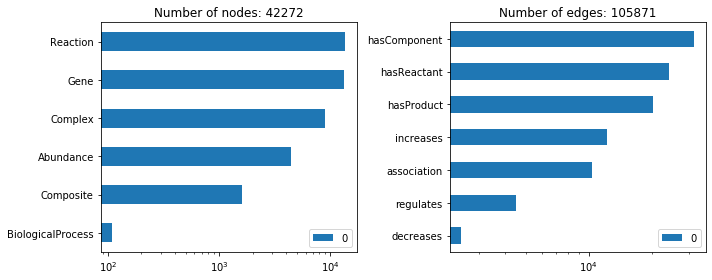

In [3]:
GRAPH_PATH = os.path.join(DEFAULT_DIFFUPATH_DIR, 'pickles', 'universe', 'pathme_universe_non_flatten_collapsed_names_no_isolates_16_03_2020.pickle')

pathme_universe_graph_no_flatten = pybel.from_pickle(GRAPH_PATH)
pathme_universe_graph_no_flatten.summarize()

nx.number_of_isolates(pathme_universe_graph_no_flatten)
pathme_universe_graph_no_flatten.remove_nodes_from({
    node
    for node in nx.isolates(pathme_universe_graph_no_flatten)
})

plot_summary(pathme_universe_graph_no_flatten, plt, figsize=(10, 4))
plt.show()

##### Import kernel

In [ ]:
KERNEL_PATH = os.path.join(DEFAULT_DIFFUPATH_DIR, 'kernels', 'kernel_regularized_pathme_universe.pickle')

kernel = process_kernel_from_file(KERNEL_PATH)

## 2. Load/import preprocessed datasets mapping 

##### Dataset 1

In [6]:
MAPPING_PATH_DATASET_1 = os.path.join(ROOT_RESULTS_DIR, 'data', 'input_mappings', 'dataset_1_mapping.json')

dataset1_mapping_by_database_and_entity = from_json(MAPPING_PATH_DATASET_1)

In [7]:
dataset1_mapping_by_database = reduce_dict_dimension(dataset1_mapping_by_database_and_entity)

dataset1_mapping_all_labels = {entity:entity_value for entity_type, entity_set in dataset1_mapping_by_database.items() for entity, entity_value in entity_set.items()}


In [8]:
dataset1_mapping_kegg = dataset1_mapping_by_database['kegg']

##### Dataset 2

In [9]:
MAPPING_PATH_DATASET2 = os.path.join(ROOT_RESULTS_DIR, 'data', 'input_mappings', 'dataset_2_mapping.json')

dataset2_mapping_by_database_and_entity = from_json(MAPPING_PATH_DATASET2)

In [10]:
dataset2_mapping_by_database = reduce_dict_dimension(dataset2_mapping_by_database_and_entity)

dataset2_mapping_all_labels = {entity:entity_value for entity_type, entity_set in dataset2_mapping_by_database.items() for entity, entity_value in entity_set.items()}

In [11]:
dataset2_mapping_kegg = dataset2_mapping_by_database['kegg']

##### Dataset 3

In [12]:
MAPPING_PATH_DATASET3 = os.path.join(ROOT_RESULTS_DIR, 'data', 'input_mappings', 'dataset_3_mapping.json')

dataset3_mapping_by_database_and_entity = from_json(MAPPING_PATH_DATASET3)

In [13]:
dataset3_mapping_by_database = reduce_dict_dimension(dataset3_mapping_by_database_and_entity)

dataset3_mapping_all_labels = {entity:entity_value for entity_type, entity_set in dataset3_mapping_by_database.items() for entity, entity_value in entity_set.items()}

## 3. Evaluation: random cross-validation by method

In [3]:
from diffupath.views import show_box_plot, fdr_barchart_three_plot

from diffupath.cross_validation import cross_validation_by_method, get_p_values, get_wilcoxon_test

from collections import defaultdict

In [4]:
metrics_by_method = defaultdict(lambda: defaultdict(lambda: list))

In [17]:
metrics_by_method['auroc']['Dataset 1'], metrics_by_method['auprc']['Dataset 1'] = cross_validation_by_method(dataset1_mapping_all_labels, 
                                                                                                              kernel, 
                                                                                                              kernel_kegg, 
                                                                                                              k = 3)

100%|██████████| 3/3 [00:36<00:00, 12.21s/it]


In [18]:
metrics_by_method['auroc']['Dataset 2'], metrics_by_method['auprc']['Dataset 2'] = cross_validation_by_method(dataset2_mapping_all_labels, 
                                                                                                               kernel, 
                                                                                                               kernel_kegg, 
                                                                                                               k = 3)

100%|██████████| 3/3 [00:34<00:00, 11.64s/it]


In [19]:
metrics_by_method['auroc']['Dataset 3'], metrics_by_method['auprc']['Dataset 3'] =  cross_validation_by_method(dataset3_mapping_all_labels, 
                                                                                                               kernel, 
                                                                                                               kernel_kegg, 
                                                                                                               k = 3)

100%|██████████| 3/3 [00:35<00:00, 11.81s/it]


### 3.1. Result metrics AUROC

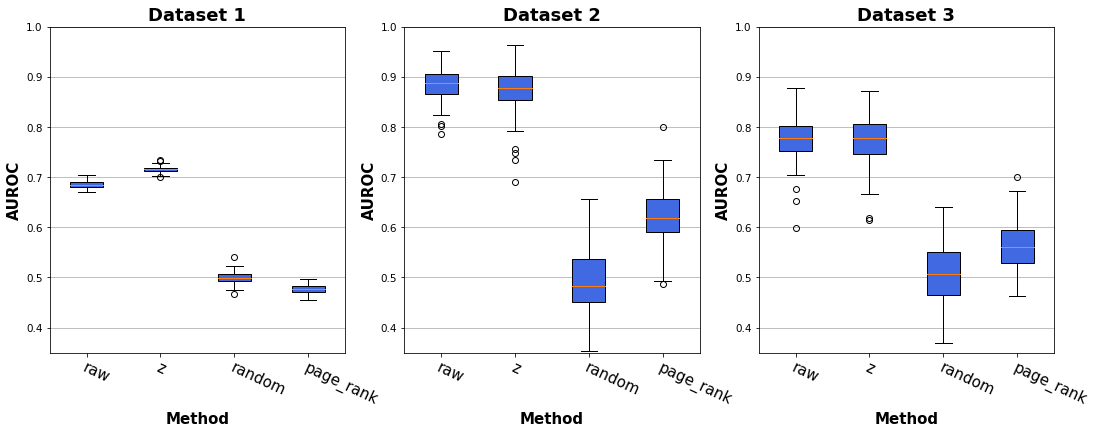

In [8]:
show_box_plot(metrics_by_method['auroc'], 'Method', 'AUROC', y_lim = [0.35, 1], color_palette = ['royalblue', 'royalblue', 'royalblue', 'royalblue'])



##### Wilcoxon test

In [9]:
df_wilcoxon = get_wilcoxon_test(metrics_by_method['auroc'], True, "AUROC")
df_wilcoxon.style.hide_index()

Dataset,Comparison AUROC,p_value,Significant difference
Dataset 1,"('raw', 'z')",3.89656e-18,True
Dataset 1,"('raw', 'random')",3.89656e-18,True
Dataset 1,"('raw', 'page_rank')",3.89656e-18,True
Dataset 1,"('z', 'random')",3.89656e-18,True
Dataset 1,"('z', 'page_rank')",3.89656e-18,True
Dataset 1,"('random', 'page_rank')",8.77788e-18,True
Dataset 2,"('raw', 'z')",0.0040036,True
Dataset 2,"('raw', 'random')",3.89656e-18,True
Dataset 2,"('raw', 'page_rank')",3.89656e-18,True
Dataset 2,"('z', 'random')",3.89656e-18,True


### 3.2. Result metrics AUPRC

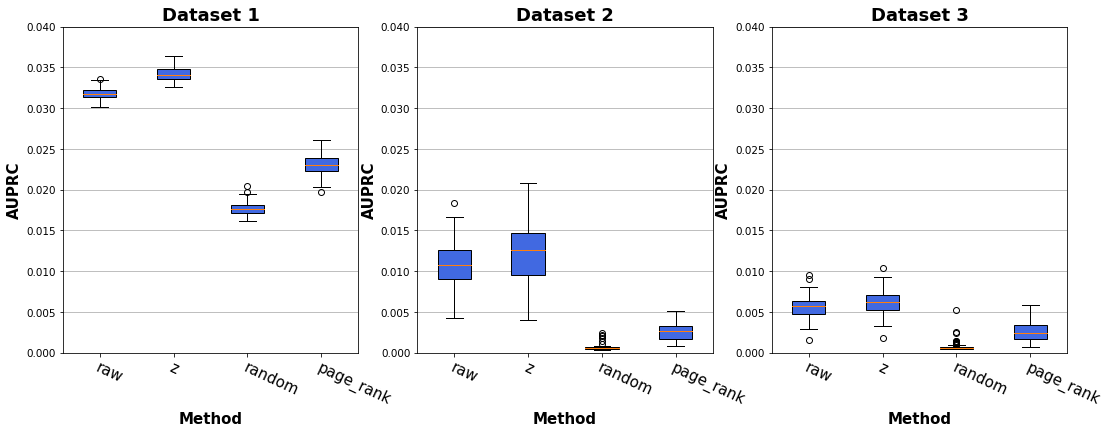

In [12]:
show_box_plot(metrics_by_method['auprc'], 'Method', 'AUPRC', y_lim = [0, 0.04],  color_palette = ['royalblue', 'royalblue', 'royalblue', 'royalblue'])


##### Wilcoxon test

In [13]:
df_wilcoxon = get_wilcoxon_test(metrics_by_method['auprc'], True, "AUPRC")
df_wilcoxon.style.hide_index()

Dataset,Comparison AUPRC,p_value,Significant difference
Dataset 1,"('raw', 'z')",3.89656e-18,True
Dataset 1,"('raw', 'random')",3.89656e-18,True
Dataset 1,"('raw', 'page_rank')",3.89656e-18,True
Dataset 1,"('z', 'random')",3.89656e-18,True
Dataset 1,"('z', 'page_rank')",3.89656e-18,True
Dataset 1,"('random', 'page_rank')",3.89656e-18,True
Dataset 2,"('raw', 'z')",3.69817e-14,True
Dataset 2,"('raw', 'random')",3.89656e-18,True
Dataset 2,"('raw', 'page_rank')",3.89656e-18,True
Dataset 2,"('z', 'random')",3.89656e-18,True


### 3.3. Export evaluation by method to  .json file

In [25]:
OUTPUT_PATH = os.path.join(ROOT_RESULTS_DIR, 'outputs', 'metrics_by_method_validation.json')
to_json(metrics_by_method, OUTPUT_PATH)

## 4. Evaluation stratified by entity: random cross-validation by method

In [20]:
from diffupath.views import show_sb_box_plot, preprocess_for_sb_boxplot, fdr_barchart_three_plot, preprocess_for_sb_ttest

from diffupath.cross_validation import cross_validation_by_method, get_p_values, get_wilcoxon_test

from collections import defaultdict


In [22]:
metrics_by_method_entity_integrated = defaultdict(lambda: defaultdict(lambda: {}))

for k1, v1 in metrics_by_method_entity.items():
    for k2, v2 in v1.items():
        metrics_by_method_entity_integrated[k1][k2]["combined_labels"] = metrics_by_method[k1][k2]
        metrics_by_method_entity_integrated[k1][k2]["gene_labels"] = v2["gene_nodes"]
        metrics_by_method_entity_integrated[k1][k2]["metabolite_labels"] = v2["metabolite_nodes"]
        
        if("mirna_nodes" in v2.keys()): metrics_by_method_entity_integrated[k1][k2]["mirna_labels"] = v2["mirna_nodes"]
        else: metrics_by_method_entity_integrated[k1][k2]["mirna_labels"] = {k: [0] * len(v) for k, v in v2["gene_nodes"].items()}
        

### 4.1. Metrics AUROC

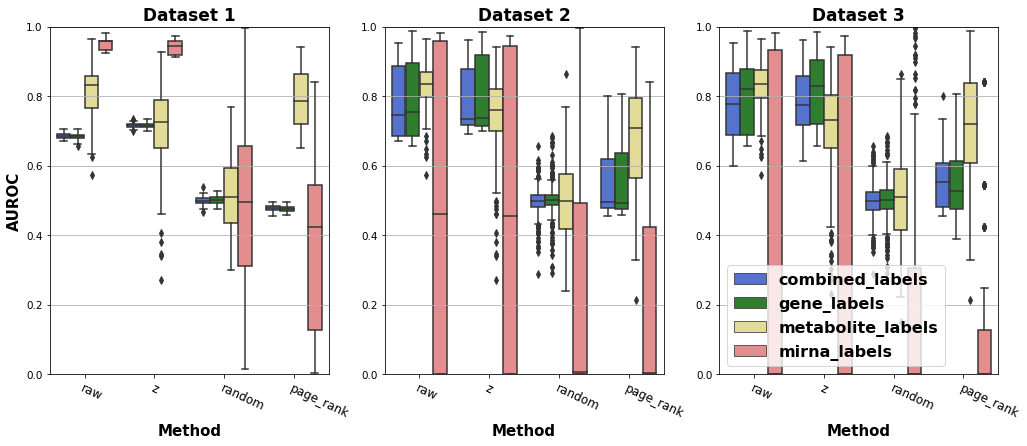

In [23]:
show_sb_box_plot(data_dict=preprocess_for_sb_boxplot(metrics_by_method_entity_integrated['auroc']),
                 x_label='Method',
                 y_label='AUROC',
                 y_lim = [0, 1]
                )


In [140]:
df_wilcoxon = get_wilcoxon_test(preprocess_for_sb_ttest(metrics_by_method_entity_integrated['auroc']), True, "AUROC")
df_wilcoxon.style.hide_index()

Dataset,Comparison AUROC,p_value,Significant difference
Dataset 1,"('raw_on_integrated_graph', 'z_on_integrated_graph')",3.89656e-18,True
Dataset 1,"('raw_on_integrated_graph', 'random_on_integrated_graph')",3.89656e-18,True
Dataset 1,"('raw_on_integrated_graph', 'page_rank_on_integrated_graph')",3.89656e-18,True
Dataset 1,"('raw_on_integrated_graph', 'raw_on_gene_subgraph')",0.369504,False
Dataset 1,"('raw_on_integrated_graph', 'z_on_gene_subgraph')",3.89656e-18,True
Dataset 1,"('raw_on_integrated_graph', 'random_on_gene_subgraph')",3.89656e-18,True
Dataset 1,"('raw_on_integrated_graph', 'page_rank_on_gene_subgraph')",3.89656e-18,True
Dataset 1,"('raw_on_integrated_graph', 'raw_on_metabolite_subgraph')",3.43391e-17,True
Dataset 1,"('raw_on_integrated_graph', 'z_on_metabolite_subgraph')",0.0247536,False
Dataset 1,"('raw_on_integrated_graph', 'random_on_metabolite_subgraph')",1.54659e-17,True


### 4.2. Metrics AUPRC

#### Genes

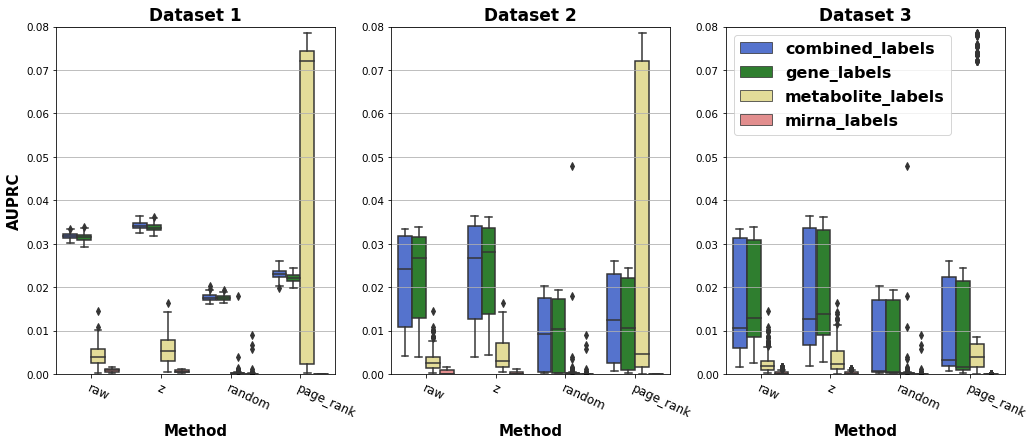

In [24]:
show_sb_box_plot(data_dict=preprocess_for_sb_boxplot(metrics_by_method_entity_integrated['auprc']),
                 x_label='Method',
                 y_label='AUPRC',
                 y_lim = [0, 0.08]
                )


In [142]:
df_wilcoxon = get_wilcoxon_test(preprocess_for_sb_ttest(metrics_by_method_entity_integrated['auprc']), True, "AUPRC")
df_wilcoxon.style.hide_index()

Dataset,Comparison AUPRC,p_value,Significant difference
Dataset 1,"('raw_on_integrated_graph', 'z_on_integrated_graph')",3.89656e-18,True
Dataset 1,"('raw_on_integrated_graph', 'random_on_integrated_graph')",3.89656e-18,True
Dataset 1,"('raw_on_integrated_graph', 'page_rank_on_integrated_graph')",3.89656e-18,True
Dataset 1,"('raw_on_integrated_graph', 'raw_on_gene_subgraph')",0.0139557,True
Dataset 1,"('raw_on_integrated_graph', 'z_on_gene_subgraph')",8.77788e-18,True
Dataset 1,"('raw_on_integrated_graph', 'random_on_gene_subgraph')",3.89656e-18,True
Dataset 1,"('raw_on_integrated_graph', 'page_rank_on_gene_subgraph')",3.89656e-18,True
Dataset 1,"('raw_on_integrated_graph', 'raw_on_metabolite_subgraph')",3.89656e-18,True
Dataset 1,"('raw_on_integrated_graph', 'z_on_metabolite_subgraph')",3.89656e-18,True
Dataset 1,"('raw_on_integrated_graph', 'random_on_metabolite_subgraph')",3.89656e-18,True
